In [ ]:
'''
Motivation: 
Find out the best statistics to mark the peak

Methods:
1) average derivative vs T 
2) Energy at S^2 =0 vs T

Tools
np.gradient

'''

# define functions

In [3]:
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import os
from astropy.io import fits

def ctr2photons_from_spec(filename, time_exp, energy_msk, energy_range):
    fak_file = fits.open(filename)
    ctr = fak_file[1].data['RATE']
    # print(ctr[energy_msk], time_exp)
    # are_all_integers(ctr[energy_msk] * time_exp)
    cts = np.array(ctr[energy_msk] * time_exp).astype(int)
    data_arr = np.repeat(energy_range[:-1], cts)
    
    return data_arr

def most_common_ele_in1darr(arr):
    u, indices, counts = np.unique(arr, return_index = True, return_counts = True)
    return u[np.argmax(counts)]


# 1) average derivative vs T 

0.1 [] nan
[]
0.2 [] nan
[]
0.30000000000000004 [] nan
[]
0.4 [0.953468 0.958336] 0.955902
[-0.97625947 -1.26620482]
0.5 [0.953468 0.958336] 0.955902
[-0.90174875 -1.14497485]
0.6 [0.717753 0.722718 0.762342 0.767283] 0.74252397
[-1.28424387 -0.62140367 -0.7389887  -1.19673846]
0.7000000000000001 [0.791949] 0.791949
[-1.79305334]
0.8 [0.816557   0.82147104] 0.819014
[-1.45431631 -1.61519893]
0.9 [0.85091496 0.855815  ] 0.85336494
[-1.19995204 -1.22768176]
1.0 [0.89006597 0.894952  ] 0.892509
[-0.90837271 -0.86243299]
1.1 [0.929111 0.933985] 0.931548
[-0.99620771 -1.0656279 ]
1.2000000000000002 [0.953468 0.958336] 0.955902
[-1.50895747 -1.60134026]
1.3000000000000003 [0.972932] 0.972932
[-1.7615387]
1.4000000000000001 [0.982658] 0.982658
[-1.63389004]
1.5000000000000002 [0.98751897 0.992379  ] 0.989949
[-1.32179977 -1.38319503]
1.6 [0.997239] 0.997239
[-1.5109429]
1.7000000000000002 [1.0021] 1.0021
[-0.94307307]
1.8000000000000003 [1.0021  1.01181 1.01667] 1.0101932
[-0.78188596 -0.7311

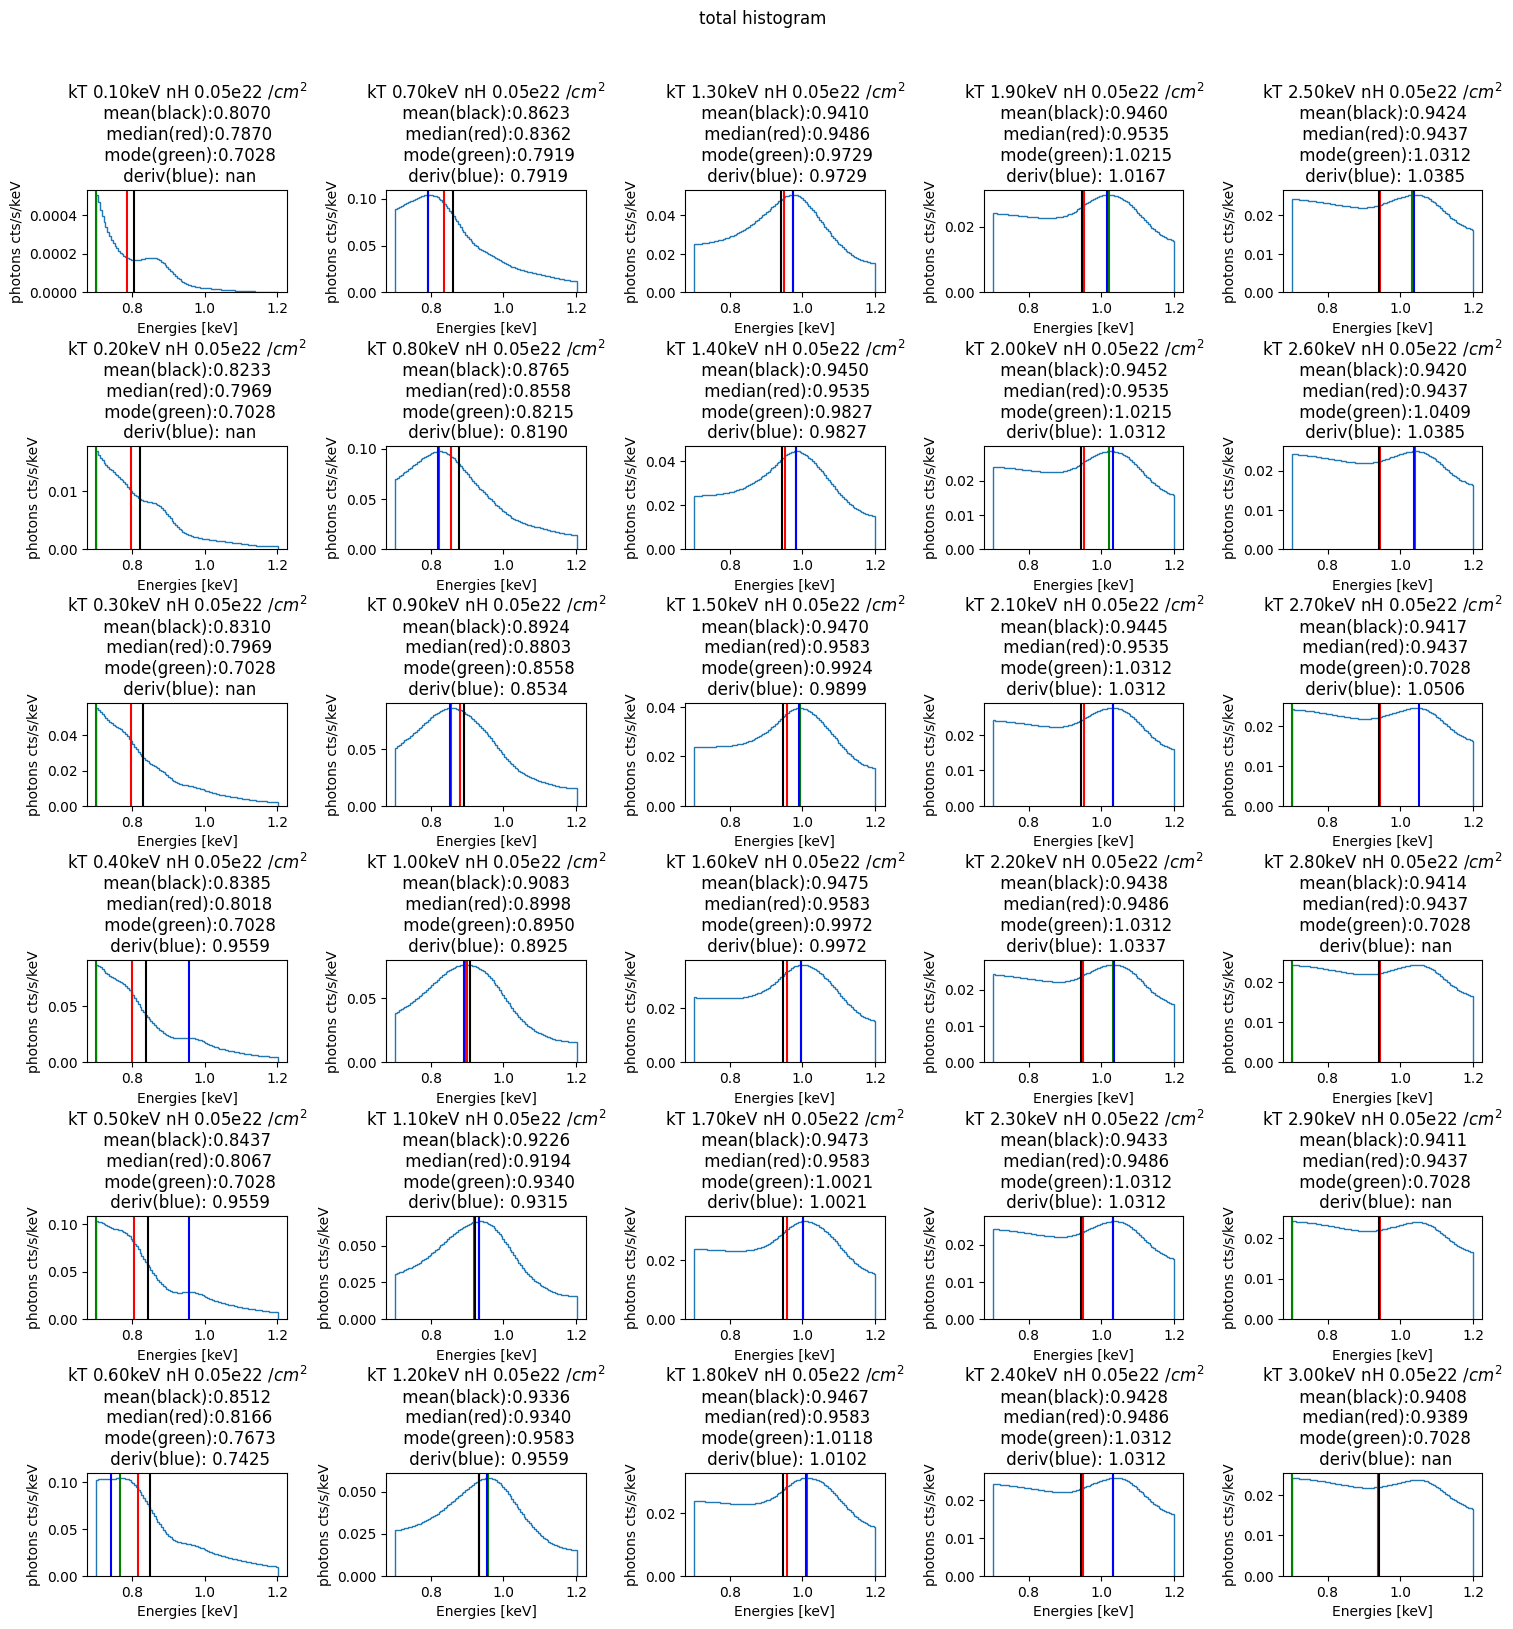

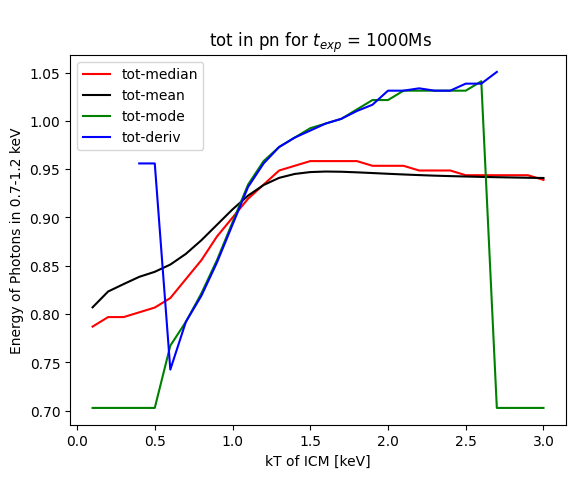

In [45]:
# basic parameters
os.chdir(f'/Users/eusracenorth/Documents/work/EXTG/ideal_mdls/mock_spectras')

INST = 'pn'
nH = 0.05 # 0.01 is the worst case in fitting, but best cases in observations
T_arr = np.arange(0.1, 3.1, 0.1)
t_exp = 1e9

# initialize  
result_dict ={}
for type in ['tot']: # 'tot', 'lines', 'cont'
    result_dict[type] = {}
    for stat in ['med', 'mean', 'mode', 'deriv']:
        result_dict[type][stat] = np.zeros(T_arr.shape)

# make the histogram plot
fig, axs = plt.subplots(6,5, figsize = (18,18), gridspec_kw={'wspace': 0.5, 'hspace': 1.5})

for i, T in enumerate(T_arr):
    
    # load and filter the energy range
    rmf_file = fits.open(f'{INST}.rmf')
    Elo = rmf_file[2].data['E_MIN']
    Ehi = rmf_file[2].data['E_MAX']
    # filter ctr in 0.7-1.2 keV
    E_msk = (Elo>0.7) & (Elo<1.2)
    E_range = np.append(Elo[E_msk], Ehi[E_msk][-1])
    # load the spectrum datas
    tot_filename = glob(f'mock*ideal-mdl_z_005_suzakunorm_15e-4_{INST}_A*_T_{T:.1f}_abun0.3_nH{nH:.2f}e22.fak')[0] 
    cts_arr = ctr2photons_from_spec(tot_filename, t_exp, E_msk, E_range)


    # do the histogram
    hist_data, __ = np.histogram(cts_arr, bins = E_range)
     
    # cal the 1nd derivative from the normalized hist_data
    deriv1 = np.gradient(hist_data/np.sum(hist_data), E_range[:-1])
    # cal the 2nd derivative 
    deriv2 = np.gradient(deriv1, E_range[:-1])

    # 1st derivative -> 0 and 2nd derivative <-1
    deriv_criteria = (abs(deriv1) < 0.005) & (deriv2<-0.6)

    deriv_line = np.mean(E_range[:-1][deriv_criteria])
    # print(np.sum(deriv_criteria))
    # # print(np.sum(deriv_criteria))
    print(T, E_range[:-1][deriv_criteria], np.mean(E_range[:-1][deriv_criteria]))
    print(deriv2[deriv_criteria])

    # plot the derivative versus the energies
    axs[int(i%6), int(i//6)].stairs(hist_data/t_exp/np.diff(E_range), E_range)
    axs[int(i%6), int(i//6)].axvline(np.median(cts_arr), color = 'r')
    axs[int(i%6), int(i//6)].axvline(np.mean(cts_arr), color = 'k')
    axs[int(i%6), int(i//6)].axvline(most_common_ele_in1darr(cts_arr), color = 'g')
    axs[int(i%6), int(i//6)].axvline(deriv_line, color = 'b')
    axs[int(i%6), int(i//6)].set_ylabel(f'photons cts/s/keV')
    axs[int(i%6), int(i//6)].set_xlabel(f'Energies [keV]')
    axs[int(i%6), int(i//6)].set_title(f'''kT {T:.2f}keV nH {nH:.2f}e22 /$cm^2$\n mean(black):{np.mean(cts_arr):.4f} \n median(red):{np.median(cts_arr):.4f}\n mode(green):{most_common_ele_in1darr(cts_arr):.4f}\n deriv(blue): {deriv_line:.4f}''')
    for type in ['tot']:
        result_dict[type]['med'][i] = np.median(cts_arr)
        result_dict[type]['mean'][i] = np.mean(cts_arr)
        result_dict[type]['mode'][i] = most_common_ele_in1darr(cts_arr)
        result_dict[type]['deriv'][i] = deriv_line
        
plt.suptitle('total histogram')
plt.show()
plt.close()

fig = plt.subplots()
plt.plot(T_arr, result_dict[type]['med'], label = f'{type}-median', c = 'r')
plt.plot(T_arr, result_dict[type]['mean'], label = f'{type}-mean', c = 'k')
plt.plot(T_arr, result_dict[type]['mode'], label = f'{type}-mode', c = 'g')
plt.plot(T_arr, result_dict[type]['deriv'], label = f'{type}-deriv', c = 'b')


plt.title(f'\n {type} in {INST} for $t_{{exp}}$ = 1000Ms')
# plt.ylabel('Counts [cts]')
plt.ylabel('Energy of Photons in 0.7-1.2 keV')
plt.xlabel('kT of ICM [keV]')
plt.legend()
plt.show()
plt.close()
